In [1]:
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm, tqdm_notebook

# Preprocessing

### Import Dataset

In [2]:
df = pd.read_csv(
    "../Datasets/Raw_Data/GSE221521_gene_expression.csv", index_col=1)
df.head()

gene_id  \
gene_name                     
AC073488.4  ENSG00000282222   
AC119427.1  ENSG00000282221   
MIR543      ENSG00000212040   
MADD        ENSG00000110514   
AL356737.2  ENSG00000287159   

                                                  description  \
gene_name                                                       
AC073488.4  chromodomain protein, Y chromosome-like (CDYL)...   
AC119427.1                novel transcript, antisense to LAD1   
MIR543       microRNA 543 [Source:HGNC Symbol;Acc:HGNC:33664]   
MADD        MAP kinase activating death domain [Source:HGN...   
AL356737.2                novel transcript, antisense to GPC5   

                       gene_type                   locus  RNA1_FPKM  \
gene_name                                                             
AC073488.4  processed_pseudogene       X:9410789-9411545   0.000000   
AC119427.1                lncRNA   1:201399633-201401190   0.000000   
MIR543                     miRNA  14:101031987-101032064   0.000000   
MADD              protein_coding    11:47269161-47330031   6.345943   
AL356737.2                lncRNA    13:92610646-92677725   0.000000   

            RNA102_FPKM  RNA104_FPKM  RNA108_FPKM  RNA109_FPKM  RNA110_FPKM  \
gene_name                                                                     
AC073488.4     0.000000     0.000000     0.000000     0.000000     0.000000   
AC119427.1     0.000000     0.000000     0.000000     0.000000     0.000000   
MIR543         0.000000     0.000000     0.000000     0.000000     0.962816   
MADD           8.482109    10.209322     7.143557     5.671481     7.776351   
AL356737.2     0.000000     0.000000     0.000000     0.000000     0.000000   

            ...  R_JS032_count  R_JS033_count  R_JS034_count  R_JS035_count  \
gene_name   ...                                                               
AC073488.4  ...              0              0              0              0   
AC119427.1  ...              0              0              0              0   
MIR543      ...              0              0              0              0   
MADD        ...           1187           1254           1767           1184   
AL356737.2  ...              0              0              0              0   

            R_JS036_count  R_JS037_count  R_JS038_count  R_JS039_count  \
gene_name                                                                
AC073488.4              0              0              1              0   
AC119427.1              0              0              0              0   
MIR543                  0              0              0              0   
MADD                 2418           1294           1254           1461   
AL356737.2              0              0              0              0   

            R_JS040_count  R_JS041_count  
gene_name                                 
AC073488.4              0              0  
AC119427.1              0              0  
MIR543                  0              0  
MADD                 1323           1795  
AL356737.2              0              0  

[5 rows x 390 columns]

### Check Gene Types

In [3]:
df['gene_type'].value_counts()

protein_coding                        19973
lncRNA                                16889
processed_pseudogene                  10162
unprocessed_pseudogene                 2612
misc_RNA                               2220
snRNA                                  1910
miRNA                                  1879
TEC                                    1057
snoRNA                                  943
transcribed_unprocessed_pseudogene      938
transcribed_processed_pseudogene        500
rRNA_pseudogene                         496
IG_V_pseudogene                         187
IG_V_gene                               145
transcribed_unitary_pseudogene          138
TR_V_gene                               106
unitary_pseudogene                       98
TR_J_gene                                79
rRNA                                     53
scaRNA                                   49
polymorphic_pseudogene                   48
IG_D_gene                                37
TR_V_pseudogene                 

### Transform the Dataset

In [4]:
df = df[df['gene_type'] == 'snoRNA']
df = df.drop(['gene_type', 'description', 'gene_id', 'locus'], axis=1)
df = df.iloc[:, :193]
df = df.T
df.to_csv('../Datasets/Dataset13/data0.csv')

### Combine with Diagnosis

In [5]:
df = pd.read_csv('../Datasets/Dataset13/data0.csv', index_col=0)
diagnosis = pd.read_csv("../Datasets/Dataset05/Diagnosis.csv", index_col=0)
df['Diagnosis'] = diagnosis['Diagnosis']
df.to_csv('../Datasets/Dataset13/data1.csv')

df.head()

SNORA10   SNORD61  AL161777.1  AC114748.1  AL135927.1  \
RNA1_FPKM    0.597310  2.176501         0.0    0.000000    0.000000   
RNA102_FPKM  0.566563  1.032232         0.0    0.526944    0.534418   
RNA104_FPKM  0.556717  2.028584         0.0    0.517786    0.000000   
RNA108_FPKM  0.604411  1.101187         0.0    0.562145    0.000000   
RNA109_FPKM  0.601479  1.095845         0.0    0.559417    0.000000   

             AC020910.1  AC092169.1  AC034186.2  SNORD15A  SNORA20B  ...  \
RNA1_FPKM           0.0         0.0         0.0  0.536772       0.0  ...   
RNA102_FPKM         0.0         0.0         0.0  2.546193       0.0  ...   
RNA104_FPKM         0.0         0.0         0.0  4.001269       0.0  ...   
RNA108_FPKM         0.0         0.0         0.0  0.543153       0.0  ...   
RNA109_FPKM         0.0         0.0         0.0  0.540518       0.0  ...   

             SNORA70.26  AC000081.2  SNORD116-1  SNORA15B-1  SNORD38B.1  \
RNA1_FPKM           0.0         0.0    0.000000    0.588461    1.185706   
RNA102_FPKM         0.0         0.0    0.000000    1.116340    1.124671   
RNA104_FPKM         0.0         0.0    0.000000    2.741757    1.105124   
RNA108_FPKM         0.0         0.0    0.000000    0.595457    1.199801   
RNA109_FPKM         0.0         0.0    0.842071    0.000000    1.193981   

             SNORA38B  SNORD117  SNORA62.6  AL139281.2  Diagnosis  
RNA1_FPKM    1.819289       0.0        0.0         0.0          1  
RNA102_FPKM  0.575213       0.0        0.0         0.0          2  
RNA104_FPKM  1.130433       0.0        0.0         0.0          1  
RNA108_FPKM  0.000000       0.0        0.0         0.0          1  
RNA109_FPKM  0.610662       0.0        0.0         0.0          0  

[5 rows x 944 columns]

### Remove Patients who hasn't Diabetic

In [6]:
df = pd.read_csv('../Datasets/Dataset13/data1.csv', index_col=0)
df = df[df['Diagnosis'] != 0]
df['Diagnosis'] = df['Diagnosis'] - 1
df.to_csv("../Datasets/Dataset13/data2.csv")
df.head()

SNORA10   SNORD61  AL161777.1  AC114748.1  AL135927.1  \
RNA1_FPKM    0.597310  2.176501         0.0    0.000000    0.000000   
RNA102_FPKM  0.566563  1.032232         0.0    0.526944    0.534418   
RNA104_FPKM  0.556717  2.028584         0.0    0.517786    0.000000   
RNA108_FPKM  0.604411  1.101187         0.0    0.562145    0.000000   
RNA110_FPKM  0.564659  1.028762         0.0    0.000000    0.000000   

             AC020910.1  AC092169.1  AC034186.2  SNORD15A  SNORA20B  ...  \
RNA1_FPKM           0.0         0.0         0.0  0.536772       0.0  ...   
RNA102_FPKM         0.0         0.0         0.0  2.546193       0.0  ...   
RNA104_FPKM         0.0         0.0         0.0  4.001269       0.0  ...   
RNA108_FPKM         0.0         0.0         0.0  0.543153       0.0  ...   
RNA110_FPKM         0.0         0.0         0.0  0.507430       0.0  ...   

             SNORA70.26  AC000081.2  SNORD116-1  SNORA15B-1  SNORD38B.1  \
RNA1_FPKM           0.0         0.0         0.0    0.588461    1.185706   
RNA102_FPKM         0.0         0.0         0.0    1.116340    1.124671   
RNA104_FPKM         0.0         0.0         0.0    2.741757    1.105124   
RNA108_FPKM         0.0         0.0         0.0    0.595457    1.199801   
RNA110_FPKM         0.0         0.0         0.0    0.556294    1.120890   

             SNORA38B  SNORD117  SNORA62.6  AL139281.2  Diagnosis  
RNA1_FPKM    1.819289       0.0        0.0         0.0          0  
RNA102_FPKM  0.575213       0.0        0.0         0.0          1  
RNA104_FPKM  1.130433       0.0        0.0         0.0          0  
RNA108_FPKM  0.000000       0.0        0.0         0.0          0  
RNA110_FPKM  0.000000       0.0        0.0         0.0          0  

[5 rows x 944 columns]

### Analyze the Dataset

In [7]:
df = pd.read_csv("../Datasets/Dataset13/data2.csv", index_col=0)
df.describe()

SNORA10     SNORD61  AL161777.1  AC114748.1  AL135927.1  AC020910.1  \
count  143.000000  143.000000  143.000000  143.000000  143.000000  143.000000   
mean     0.585912    1.115354    0.030048    0.198334    0.224713    0.192694   
std      0.106391    1.409589    0.168876    0.320562    0.350669    0.440423   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.559006    0.675611    0.000000    0.000000    0.000000    0.000000   
50%      0.597589    1.087660    0.000000    0.000000    0.000000    0.000000   
75%      0.629435    1.200294    0.000000    0.532552    0.519114    0.000000   
max      0.836845   14.882398    1.446904    1.464043    1.436807    2.170981   

       AC092169.1  AC034186.2    SNORD15A  SNORA20B  ...  SNORA70.26  \
count       143.0  143.000000  143.000000     143.0  ...  143.000000   
mean          0.0    0.043579    1.099370       0.0  ...    0.113566   
std           0.0    0.152696    0.950182       0.0  ...    0.306313   
min           0.0    0.000000    0.000000       0.0  ...    0.000000   
25%           0.0    0.000000    0.526780       0.0  ...    0.000000   
50%           0.0    0.000000    0.670393       0.0  ...    0.000000   
75%           0.0    0.000000    1.583201       0.0  ...    0.000000   
max           0.0    0.646795    5.788929       0.0  ...    2.060415   

       AC000081.2  SNORD116-1  SNORA15B-1  SNORD38B.1    SNORA38B    SNORD117  \
count  143.000000  143.000000  143.000000  143.000000  143.000000  143.000000   
mean     0.005948    0.046658    0.833806    1.172163    0.542640    0.157374   
std      0.071133    0.183854    0.873213    0.187413    0.536331    0.400578   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.404023    1.110793    0.000000    0.000000   
50%      0.000000    0.000000    0.594430    1.187374    0.594721    0.000000   
75%      0.000000    0.000000    1.179715    1.254563    0.783496    0.000000   
max      0.850624    0.946943    5.047377    1.661199    1.953628    2.189799   

       SNORA62.6  AL139281.2   Diagnosis  
count      143.0       143.0  143.000000  
mean         0.0         0.0    0.468531  
std          0.0         0.0    0.500763  
min          0.0         0.0    0.000000  
25%          0.0         0.0    0.000000  
50%          0.0         0.0    0.000000  
75%          0.0         0.0    1.000000  
max          0.0         0.0    1.000000  

[8 rows x 944 columns]

In [8]:
df.dtypes

SNORA10       float64
SNORD61       float64
AL161777.1    float64
AC114748.1    float64
AL135927.1    float64
               ...   
SNORA38B      float64
SNORD117      float64
SNORA62.6     float64
AL139281.2    float64
Diagnosis       int64
Length: 944, dtype: object

In [9]:
df.isnull().sum()

SNORA10       0
SNORD61       0
AL161777.1    0
AC114748.1    0
AL135927.1    0
             ..
SNORA38B      0
SNORD117      0
SNORA62.6     0
AL139281.2    0
Diagnosis     0
Length: 944, dtype: int64

# Feature Selection

### Select best Feature Selection Algorithm

In [10]:
df = pd.read_csv("../Datasets/Dataset13/data2.csv", index_col=0)

features = df.drop('Diagnosis', axis=1)
target = df['Diagnosis']

result_df = pd.DataFrame(
    columns=['Feature Selection Algorithm', 'Feature Count', 'Cross Validation Score'])

feature_counts = [25, 50, 100, 150, 200]

feature_selection_algorithms = [
    ('Information Gain (Mutual info)', mutual_info_classif),
    ('Correlation Coefficient', f_classif),
    ('Chi-Square', chi2),
    ('Feature Importance', RandomForestClassifier().fit(
        features, target).feature_importances_)
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for algo_name, algo_func in feature_selection_algorithms:
    for count in feature_counts:
        if algo_name == 'Feature Importance':
            selected_features = features.columns[algo_func.argsort(
            )[-count:][::-1]]
        else:
            selected_features = features.columns[algo_func(
                features, target)[0].argsort()[-count:][::-1]]

        clf = SVC(kernel='linear')
        cv_scores = cross_val_score(
            clf, features[selected_features], target, cv=cv)

        result_df = pd.concat([result_df, pd.DataFrame({
            'Feature Selection Algorithm': [algo_name],
            'Feature Count': [count],
            'Cross Validation Score': [f'{cv_scores.mean():.2f}+/-{cv_scores.std():.2f}']
        })], ignore_index=True)

print(result_df)

c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  6   9  11  13  14  26  31  33  37  38  39  40  42  45  49  50  51  52
  54  57  62  64  68  69  70  71  76  77  80  82  88  89  90 101 102 106
 109 110 112 114 129 130 135 139 140 141 143 152 158 160 162 173 176 179
 181 183 184 185 186 189 190 194 196 197 199 202 204 206 209 219 223 225
 226 229 241 245 249 251 254 255 261 262 263 269 271 272 279 280 283 284
 286 288 292 297 298 300 301 303 308 310 320 321 326 327 328 329 334 342
 346 347 352 353 356 361 363 364 365 366 367 368 369 370 385 387 388 391
 396 399 403 408 412 414 416 417 419 420 423 425 426 431 432 436 438 439
 440 446 447 448 451 457 459 461 462 463 465 466 468 474 475 477 480 481
 486 488 490 493 494 503 506 508 510 515 516 517 520 524 526 527 528 538
 539 545 547 549 553 554 555 556 557 560 562 566 572 575 576 578 580 582
 583 584 586 597 598 601 605 606 607 617 620 622 627 630 631 639 643 645
 651

       Feature Selection Algorithm Feature Count Cross Validation Score
0   Information Gain (Mutual info)            25            0.53+/-0.09
1   Information Gain (Mutual info)            50            0.53+/-0.09
2   Information Gain (Mutual info)           100            0.53+/-0.09
3   Information Gain (Mutual info)           150            0.53+/-0.09
4   Information Gain (Mutual info)           200            0.53+/-0.09
5          Correlation Coefficient            25            0.53+/-0.09
6          Correlation Coefficient            50            0.53+/-0.09
7          Correlation Coefficient           100            0.53+/-0.09
8          Correlation Coefficient           150            0.53+/-0.09
9          Correlation Coefficient           200            0.53+/-0.09
10                      Chi-Square            25            0.53+/-0.09
11                      Chi-Square            50            0.53+/-0.09
12                      Chi-Square           100            0.53

### Check Feature Importance

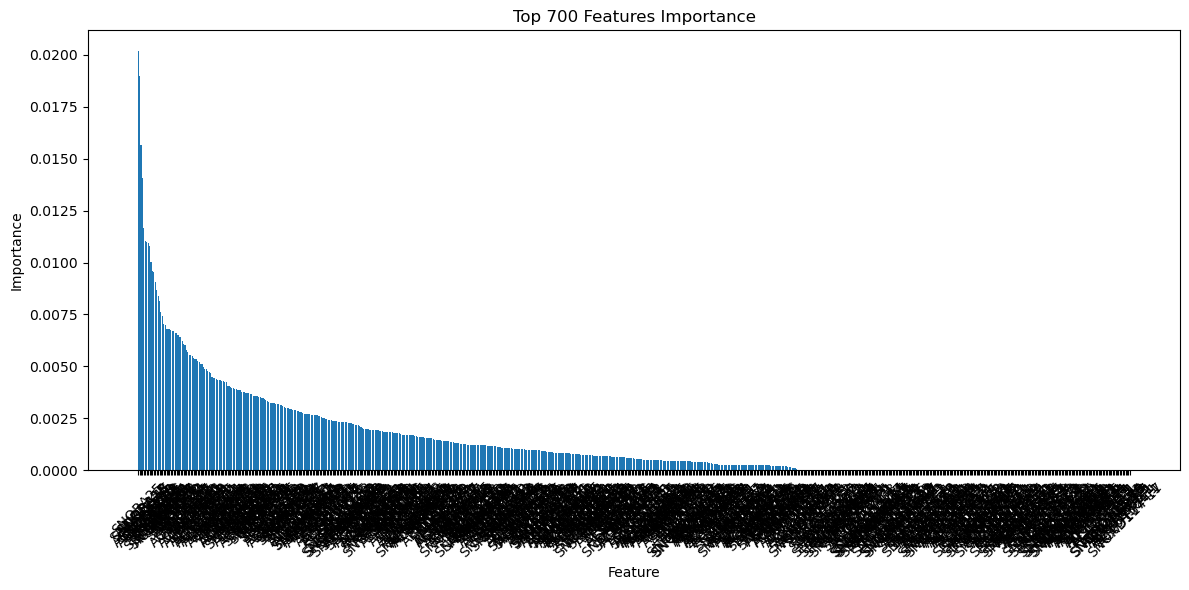

Last important feature:  465


In [11]:
df = pd.read_csv("../Datasets/Dataset13/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_names = X.columns

k_values = [700]

selected_features_dict = {}

for k in k_values:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    feature_importances = clf.feature_importances_
    selected_features = np.array(feature_names)[
        np.argsort(feature_importances)[::-1][:k]]

    selected_features_dict[k] = selected_features

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f"Top {k} Features Importance")
    plt.bar(range(k), feature_importances[sorted_idx][:k], align="center")
    plt.xticks(range(k), np.array(feature_names)[sorted_idx][:k], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

    zero_importance_index = np.where(feature_importances == 0)[0]
    print("Last important feature: ", len(
        X.columns)-len(zero_importance_index))

### Feature Selection

In [12]:
df = pd.read_csv("../Datasets/Dataset13/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_counts = list(range(1, 144))

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

feature_importances = clf.feature_importances_

selected_features = X.columns[np.argsort(feature_importances)[::-1]]

datasets = {}
for count in feature_counts:
    datasets[count] = X[selected_features[:count]].copy()
    datasets[count]['Diagnosis'] = y

for count, dataset in datasets.items():
    dataset.to_csv(
        f'../Datasets/Dataset13/Feature_Select/dataset_{count}.csv', index=True)

## Model Building

### Check CV Score for Different Models

In [13]:
feature_counts = list(range(1, 144))

models = {
    "SVM(linear)": SVC(kernel='linear'),
    "SVM(poly)": SVC(kernel='poly'),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "ANN": MLPClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

results = pd.DataFrame(
    columns=["Model Name", "Feature Count", "CV Score (Mean +/- Std)"])

for count in tqdm(feature_counts, desc="Processing feature counts", unit=" feature counts", colour='green'):
    file_path = f"../Datasets/Dataset13/Feature_Select/dataset_{count}.csv"
    df = pd.read_csv(file_path, index_col=0)

    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']

    for model_name, model in models.items():
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        if model_name == "ANN":
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        elif model_name == "Logistic Regression": 
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        else:
            scores = cross_val_score(model, X, y, cv=cv)
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        result = f"{mean_score:.4f} +/- {std_score:.4f}"
        new_data = pd.DataFrame({"Model Name": [model_name],
                                 "Feature Count": [count],
                                 "CV Score (Mean +/- Std)": [result]})
        results = pd.concat([results, new_data], ignore_index=True)
        # print(f"{model_name} with {count} features: {result}")

results.sort_values(by=["CV Score (Mean +/- Std)"],
                    ascending=False, inplace=True)
results.to_csv("../Datasets/Dataset13/Feature_Select/results.csv", index=False)

Processing feature counts: 100%|██████████| 143/143 [05:40<00:00,  2.38s/ feature counts]


In [14]:
df = pd.read_csv("../Datasets/Dataset13/Feature_Select/results.csv")
df.head(10)

Model Name  Feature Count CV Score (Mean +/- Std)
0  Random Forest             11       0.7931 +/- 0.0786
1  Random Forest             55       0.7931 +/- 0.0436
2  Random Forest             84       0.7862 +/- 0.0552
3  Random Forest             68       0.7862 +/- 0.0402
4    Naive Bayes             50       0.7862 +/- 0.0258
5    Naive Bayes             51       0.7862 +/- 0.0258
6  Random Forest             90       0.7862 +/- 0.0258
7  Random Forest             76       0.7793 +/- 0.0601
8  Random Forest            100       0.7793 +/- 0.0468
9    Naive Bayes             47       0.7793 +/- 0.0352

### Check Distributions

In [17]:
feature_count = 55

data = pd.read_csv(
    f'../Datasets/Dataset13/Feature_Select/dataset_{feature_count}.csv')

target_column = data.columns[feature_count + 1]

num_rows = math.ceil(feature_count / 4)
num_columns = 4

fig, axes = plt.subplots(num_rows, num_columns, figsize=(80, 140))

for i in range(min(feature_count, num_rows * num_columns)):
    row_index = i // num_columns
    col_index = i % num_columns

    sns.histplot(
        data=data, x=data.columns[i + 1], hue=target_column, kde=True, ax=axes[row_index, col_index])

    axes[row_index, col_index].set_title(
        f'Distribution of {data.columns[i + 1]}')

    axes[row_index, col_index].set_xlabel(data.columns[i + 1])

    axes[row_index, col_index].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

### Check Accuracy

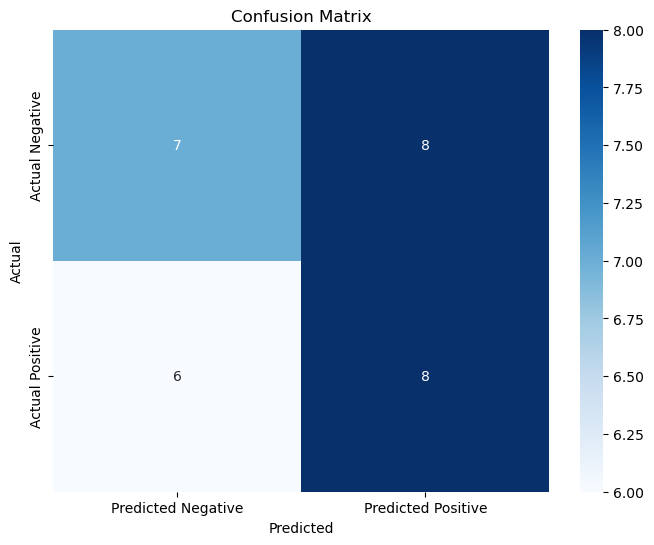

Accuracy: 0.52
Precision: 0.50
Recall (Sensitivity): 0.57
Specificity: 0.47
F1 Score: 0.53


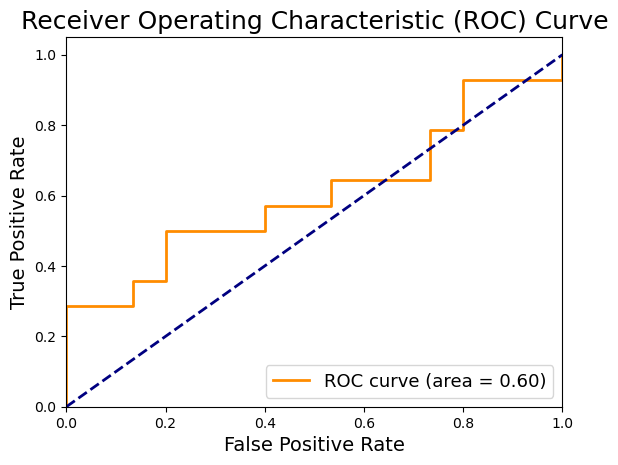

In [18]:
feature_count = 55

df = pd.read_csv(
    f'../Datasets/Dataset13/Feature_Select/dataset_{feature_count}.csv', index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

y_scores = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=13)
plt.show()